# Word2Vec

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 19.59 MiB/s, done.
Resolving deltas: 100% (139/139), done.
     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 1.7MB 14.9MB/s 
     |████████████████████████████████| 24.2MB 1.4MB/s 
     |████████████████████████████████| 307kB 46.3MB/s 
     |████████████████████████████████| 8.2MB 35.4MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=f0786d3ee5a5bde472cf55c2fbff217af9adab6588c63d52f5224aa4ecc8d4a4
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp37-cp37m-linux_x86_64.whl size=5626623 sha256=d67feb3501073ab3a98d8c

In [3]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

In [4]:
import sys
import ast
import numpy as np
import time
import scipy.sparse
from itertools import permutations, combinations


## Разные задания из семинара

### Sliding window

In [5]:


def generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=True, list_compr=False, allocfirst=False):
    """
    text - list of integer numbers - ids of tokens in text
    window_size - odd integer - width of window
    vocab_size - positive integer - number of tokens in vocabulary
    ns_rate - positive integer - number of negative tokens to sample per one positive sample

    returns list of training samples (CenterWord, CtxWord, Label)
    """
    halfstep = window_size // 2
    tstart = time.perf_counter()
    n_txt = len(text)
    if naive:
        res = []
        for i in range(n_txt):
            for j in range(-halfstep, halfstep + 1):
                if halfstep != 0 and j == 0:
                    continue
                if i + j < 0 or i + j >= n_txt:
                    continue
                res.append([text[i], text[i + j], 1])
                for k in range(ns_rate):
                    res.append([text[i], np.random.randint(0, vocab_size), 0])
    elif list_compr:
        res = [[text[i], text[i + j], 1] if k == -1 else [text[i], np.random.randint(0, vocab_size), 0] 
                                           for i in range(n_txt)
                                           for j in range(-halfstep, halfstep + 1) if ((i + j >= 0 and i + j < n_txt) and ((j != 0 and halfstep > 0) or (halfstep == 0)))
                                           for k in range(-1, ns_rate) 
            ]
    elif not allocfirst:
        ndx = [[i, i + j] for i in range(n_txt) for j in range(-halfstep, halfstep + 1) if ((i + j >= 0 and i + j < n_txt) and ((j != 0 and halfstep > 0) or (halfstep == 0)))]
        n_pos = len(ndx)
        ndx = np.ravel(ndx)
        res = text[ndx].reshape(n_pos, 2)
        res = np.append(res, np.ones((n_pos, 1), dtype=int), axis=1)
        for ineg in range(ns_rate):
            res = np.append(res, res[:, :1], axis=1)
            res = np.append(res, np.random.randint(0, vocab_size, (n_pos, 1)), axis=1)
            res = np.append(res, np.zeros((n_pos, 1), dtype=int), axis=1)
        res = res.reshape((n_pos * (ns_rate + 1) , 3))

    else:
        ndx = [[i, i + j] for i in range(n_txt) for j in range(-halfstep, halfstep + 1) if ((i + j >= 0 and i + j < n_txt) and ((j != 0 and halfstep > 0) or (halfstep == 0)))]
        n_pos = len(ndx)
        ndx = np.ravel(ndx)
        res = np.zeros((n_pos, (ns_rate + 1) * 3), dtype=int)
        res[:, :2] = text[ndx].reshape(n_pos, 2)
        res[:, 2] = 1
        for ineg in range(ns_rate):
            ineg3 = 3 + ineg * 3
            res[:, ineg3] = res[:, 0]
            res[:, ineg3 + 1] = np.random.randint(0, vocab_size, n_pos)
            res[:, ineg3 + 2] = 0
        res = res.reshape((n_pos * (ns_rate + 1) , 3))

    tstop = time.perf_counter()

        
    return res, tstop - tstart



In [6]:

text = np.array([1, 0, 1, 0, 0, 5, 0, 3, 5, 5, 3, 0, 5, 0, 5, 2, 0, 1, 3])
text = np.array([ 1,  6,  1,  0, -7])
window_size = 3
vocab_size = 4
ns_rate = 1

result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate)
print(result, tm)

result3, tm =  generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False, list_compr=True)
print(result3, tm)

result1, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False)
print(result1.tolist(), tm)

result2, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False, allocfirst=True)
print(result2.tolist(), tm)

[[1, 6, 1], [1, 0, 0], [6, 1, 1], [6, 3, 0], [6, 1, 1], [6, 1, 0], [1, 6, 1], [1, 0, 0], [1, 0, 1], [1, 3, 0], [0, 1, 1], [0, 3, 0], [0, -7, 1], [0, 3, 0], [-7, 0, 1], [-7, 3, 0]] 0.00011008000001311302
[[1, 6, 1], [1, 1, 0], [6, 1, 1], [6, 3, 0], [6, 1, 1], [6, 1, 0], [1, 6, 1], [1, 2, 0], [1, 0, 1], [1, 0, 0], [0, 1, 1], [0, 3, 0], [0, -7, 1], [0, 2, 0], [-7, 0, 1], [-7, 0, 0]] 7.274000006418646e-05
[[1, 6, 1], [1, 0, 0], [6, 1, 1], [6, 0, 0], [6, 1, 1], [6, 2, 0], [1, 6, 1], [1, 1, 0], [1, 0, 1], [1, 2, 0], [0, 1, 1], [0, 3, 0], [0, -7, 1], [0, 3, 0], [-7, 0, 1], [-7, 2, 0]] 0.007825342000046476
[[1, 6, 1], [1, 0, 0], [6, 1, 1], [6, 1, 0], [6, 1, 1], [6, 1, 0], [1, 6, 1], [1, 1, 0], [1, 0, 1], [1, 1, 0], [0, 1, 1], [0, 0, 0], [0, -7, 1], [0, 1, 0], [-7, 0, 1], [-7, 0, 0]] 0.0001300100000207749


In [ ]:
conditions = ((10, 20, 3, 2),
              (10, 20, 3, 10),
              (1000, 1000, 3, 2),
              (1000, 1000, 11, 2),
              (10000, 10000, 5, 5),
              (100000, 100000, 5, 3),
              (1000000, 1000000, 5, 3),
              )


for text_size, vocab_size, window_size, ns_rate in conditions:
    tms1, tms2, tms3, tms4 = [], [], [], []
    text = np.random.randint(0, vocab_size, text_size)

    for i in range(10):
        result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate)
        tms1.append(tm)

        result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False, list_compr=True)
        tms2.append(tm)

        result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False)
        tms3.append(tm)

        result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False, allocfirst=True)
        tms4.append(tm)
    print('text_size = {0}, vocab_size = {1}, window_size = {2}, ns_rate = {3}'.format(text_size, vocab_size, window_size, ns_rate))
    print('naive with 3 for loops              ', np.mean(tms1))
    print('naive with list comprehensions      ', np.mean(tms2))
    print('vector-style with np.append         ', np.mean(tms3))
    print('vector-style with preallocated array', np.mean(tms4))
    print()

text_size = 10, vocab_size = 20, window_size = 3, ns_rate = 2
naive with 3 for loops               0.0001862765995610971
naive with list comprehensions       0.00017768639991118108
vector-style with np.append          0.00014846030026092195
vector-style with preallocated array 8.90219998836983e-05

text_size = 10, vocab_size = 20, window_size = 3, ns_rate = 10
naive with 3 for loops               0.0007047139002679615
naive with list comprehensions       0.0006360382998536806
vector-style with np.append          0.0006021432003763038
vector-style with preallocated array 0.0004060101000504801

text_size = 1000, vocab_size = 1000, window_size = 3, ns_rate = 2
naive with 3 for loops               0.01615346100043098
naive with list comprehensions       0.015966681799909566
vector-style with np.append          0.003151491800235817
vector-style with preallocated array 0.0030787818996032

text_size = 1000, vocab_size = 1000, window_size = 11, ns_rate = 2
naive with 3 for loops               

### GloVe mutual occurence

In [5]:
# from itertools import permutations
# from itertools import combinations

def generate_coocurrence_matrix(texts, vocab_size, naive=True, naive2=False, perm=False, comb_set=False):
    """
    texts - list of lists of ints - i-th sublist contains identifiers of tokens in i-th document
    vocab_size - int - size of vocabulary
    returns scipy.sparse.dok_matrix
    """
    tstart = time.perf_counter()
    mutual_occurence = scipy.sparse.dok_matrix((vocab_size, vocab_size), dtype=int)
    if naive:
        for text in texts:
            dk_loc = scipy.sparse.dok_matrix((vocab_size, vocab_size), dtype=int)
            for i, vi in enumerate(text):
                for j, vj in enumerate(text):
                    if i <= j or vi == vj:
                        continue
                    dk_loc[vi, vj] = 1
                    dk_loc[vj, vi] = 1
            mutual_occurence += dk_loc
    elif naive2:
        for i in range(vocab_size):
            for j in range(vocab_size):
                if i <= j:
                    continue
                for text in texts:
                    if i in text and j in text:
                        mutual_occurence[i, j] += 1
                        mutual_occurence[j, i] += 1
    elif perm:
        for text in texts:
            cur_comb = set(permutations(text, 2))
            for vi, vj in cur_comb:
                if vi == vj:
                    continue
                mutual_occurence[vi, vj] += 1
    elif comb_set:
        for text in texts:
            combs = combinations(set(text), 2)
            for vi, vj in combs:
                mutual_occurence[vi, vj] += 1
                mutual_occurence[vj, vi] += 1
    tstop = time.perf_counter()
    return mutual_occurence, tstop - tstart


text = [[0, 2, 2, 2, 0, 0], [1, 1, 2, 1, 1], [2, 2, 1, 1]]
vocab_size = 3

result, tm = generate_coocurrence_matrix(text, vocab_size)
print(result.A)
result, tm = generate_coocurrence_matrix(text, vocab_size, naive=False, perm=True)
print(result.A)

[[0 0 1]
 [0 0 2]
 [1 2 0]]
[[0 0 1]
 [0 0 2]
 [1 2 0]]


In [6]:
conditions = ((10, 10, 10),
              (10, 1000, 10),
              (1000, 10, 10),
              (10, 10, 1000),
              (10, 10, 10000),
              (100, 1000, 1000),
              (100, 100, 1000),
              (10, 10000, 10000),
              (100, 1000, 100000),
              )

for n_texts, text_len, vocab_size in conditions:
    tms1, tms2, tms3, tms4 = [], [], [], []
    text = np.random.randint(0, vocab_size, (n_texts, text_len))
    for i in range(10):
        res, tm1 = generate_coocurrence_matrix(text, vocab_size)
        tms1.append(tm1)
        res, tm2 = generate_coocurrence_matrix(text, vocab_size, naive=False, naive2=True)
        tms2.append(tm2)
        res, tm3 = generate_coocurrence_matrix(text, vocab_size, naive=False, perm=True)
        tms3.append(tm3)
        res, tm4 = generate_coocurrence_matrix(text, vocab_size, naive=False, comb_set=True)
        tms4.append(tm4)
    print('Number of texts = {0}, text size = {1}, vocabulary size = {2}'.format(n_texts, text_len, vocab_size))
    print('Naive iteration, iterating over texts and words inside of them', np.mean(tms1))
    print('Naive iteration, iterating over words and then over texts', np.mean(tms2))
    print('With itertools.permutations', np.mean(tms3))
    print('With itertools.combinations over a set', np.mean(tms4))
    print('')



# Word embeddings

## Загрузка данных и подготовка корпуса

In [7]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [8]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


In [9]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]


In [10]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 649 648
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


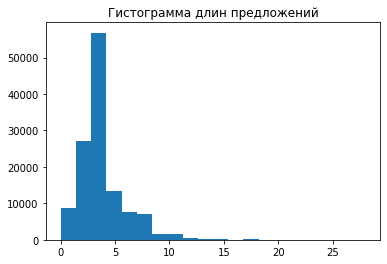

In [11]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [12]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([222,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [14]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

**Negative Sampling** работает следующим образом - мы **максимизируем сумму вероятностей двух событий**: 

* "этот пример центрального слова вместе с контекстными словами взят **из тренировочной выборки**": $$ P(y=1 | CenterW_i; CtxW_j) = sigmoid(w_i \cdot d_j) = \frac{1}{1+e^{-w_i \cdot d_j}} $$

$$ \\ $$

* "этот пример центрального слова вместе со случайми контекстными словами **выдуман** ": $$ P(y=0 | CenterW_i; CtxW_{noise}) = 1 - P(y=1 | CenterW_i;  CtxW_{noise}) = \frac{1}{1+e^{w_i \cdot d_{noise}}} $$

$$ \\ $$

$$ NEG(CtxW_j, CenterW_i) = log(\frac{1}{1+e^{-w_i \cdot d_j}}) + \sum_{l=1}^{k}log(\frac{1}{1+e^{w_i \cdot d_{noise_l}}})  \rightarrow \max_{W,D} $$

* Помним, что совместная_встречаемость ~= W * D. То есть каждый раз, считая w_i*d_j, мы берем аппроксимацию совместной встречаемости двух слов. Как бы сравниваем их контексты.

In [18]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        # nn.Embedding is a simple lookup table that stores embeddings of a fixed dictionary and size
        # Variables:
        # Embedding.weight (Tensor) – the learnable weights of the module of shape (num_embeddings, embedding_dim) 
        # initialized from N(0,1) distribution (not good for word2vec!)
        
        # center_embedding, or w, dim(w) = (voc_size, emb_size)
        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0  # padding, тк у нас в словаре нулевой вектор -- это ничто. Вот поэтому нулевому вектору тут нули сообщаем. Он не будет обучаться.

        # context_embedding, or d, dim(d) = (emb_size, voc_size)
        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        # batch matrix multiplication
        # Получаем набор матриц, содержащих оценку близости между парами токенов в одном предложении. Как бы по матрице на предложение. 
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        # И преобразуем эти оценки в вероятности (сигмоида в 0,1 преобразует):
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе (парам вне маски зануляем вероятность)
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))  # маска размножится на все матрицы в батче

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        # тут уже без сигмоиды в начале
        # сравниваем с НУЛЯМИ => отрицательные примеры
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [16]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [17]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=2,
                                            batch_size=8,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 11.76 сек
Среднее значение функции потерь на обучении 0.8884702925083936
Среднее значение функции потерь на валидации 0.8818924482509616
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 10.83 сек
Среднее значение функции потерь на обучении 0.8804204566427495
Среднее значение функции потерь на валидации 0.8781232275540316
Новая лучшая модель!



In [19]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), './stepik-dl-nlp/models/sgns.pth')

In [20]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('./stepik-dl-nlp/models/sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [21]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [22]:
embeddings.most_similar('chicken')

[('chicken', 0.999933),
 ('stock', 0.6462235),
 ('breast', 0.5978763),
 ('sodium', 0.5864094),
 ('duck', 0.5678356),
 ('turkey', 0.56518),
 ('bones', 0.5617287),
 ('veal', 0.55638707),
 ('homemade', 0.550942),
 ('neck', 0.5401327)]

In [23]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cheese', 0.9491738),
 ('romano', 0.83784455),
 ('pecorino', 0.82678676),
 ('ricotta', 0.8200719),
 ('cheddar', 0.78993255),
 ('gruyere', 0.7884755),
 ('container', 0.7651142),
 ('goat', 0.76098686),
 ('parmesan', 0.7510348),
 ('sharp', 0.7444193)]

In [32]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


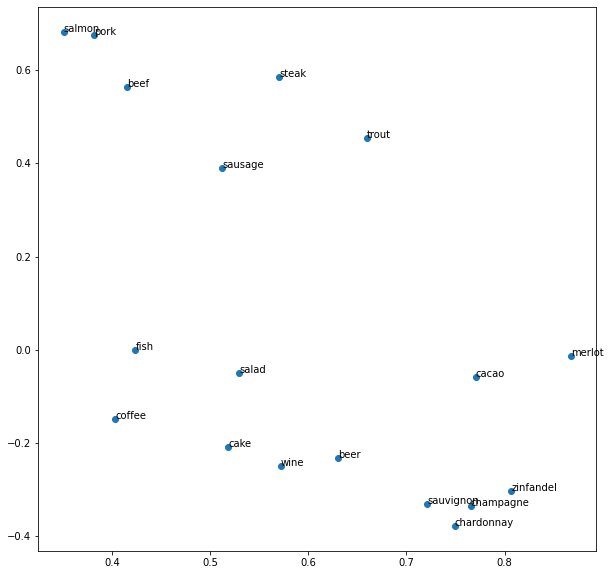

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [34]:
import gensim

In [35]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [36]:
word2vec.wv.most_similar('chicken')

[('duck', 0.7485507726669312),
 ('thighs', 0.7235167026519775),
 ('simmering', 0.6907335519790649),
 ('turkey', 0.6861485242843628),
 ('breasts', 0.6859372854232788),
 ('drumsticks', 0.6790745258331299),
 ('pheasant', 0.6750843524932861),
 ('defatted', 0.6738141775131226),
 ('rabbit', 0.6688282489776611),
 ('legs', 0.6599000692367554)]

In [37]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

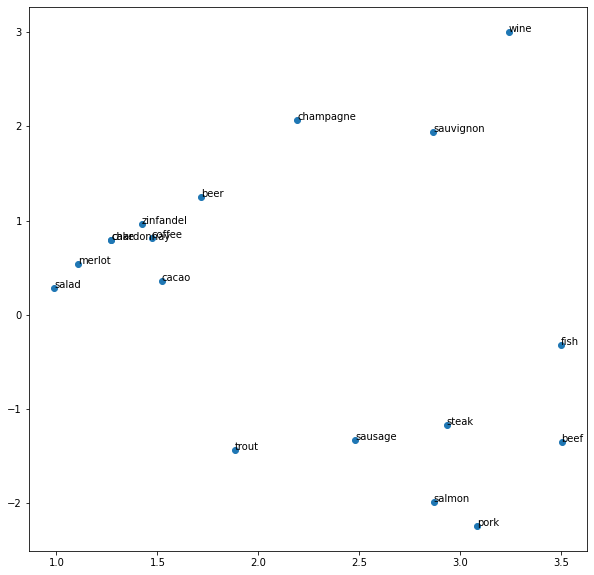

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [20]:
import gensim.downloader as api

In [21]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [22]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [23]:
pretrained.most_similar('cheese')

[('cheeses', 0.7789000272750854),
 ('cheddar', 0.7627596855163574),
 ('goat_cheese', 0.7297402620315552),
 ('Cheese', 0.7286962866783142),
 ('cheddar_cheese', 0.7255136966705322),
 ('Cheddar_cheese', 0.6943708658218384),
 ('mozzarella', 0.6805709600448608),
 ('cheddar_cheeses', 0.6694672703742981),
 ('Camembert', 0.6623163223266602),
 ('gruyere', 0.6615148186683655)]

In [25]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

[('woman', 0.7609435319900513),
 ('girl', 0.6139994263648987),
 ('teenage_girl', 0.6040961742401123),
 ('teenager', 0.5825759172439575),
 ('lady', 0.5752554535865784),
 ('boy', 0.5077576637268066),
 ('policewoman', 0.5066847801208496),
 ('schoolgirl', 0.5052095651626587),
 ('blonde', 0.48696184158325195),
 ('person', 0.48637545108795166)]

In [39]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

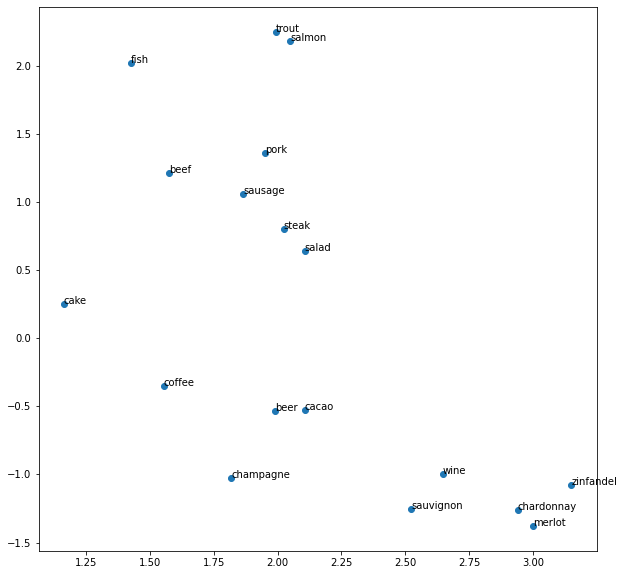

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают